# Basic Formulas 

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_rho(lambda_i, N, m, mu_i):
    return lambda_i / (N * m * mu_i)

In [3]:
def compute_pi_0(lambda_i, N, m, mu_i, K):
    rho_i = compute_rho(lambda_i, N, m, mu_i)
    res = 1

    if rho_i != 1:
        res += sum(((m*rho_i) ** k) / sp.factorial(k) for k in range(1, m))
        res += ((1 - (rho_i**(K-m+1)))*pow(m*rho_i, m)) / \
            (sp.factorial(m)*(1-rho_i))

    else:
        res += sum((m**k)/sp.factorial(k) for k in range(1, m))
        res += (m**m) * (K-m+1)/sp.factorial(m)

    return 1/res

In [4]:
def compute_pi_n(lambda_i, N, m, mu_i, K, n):
    pi_0 = compute_pi_0(lambda_i, N, m, mu_i, K)
    rho_i = compute_rho(lambda_i, N, m, mu_i)

    if n < m:
        res = (m*rho_i) ** n / sp.factorial(n)
    else:
        res = (rho_i**n) * (m**m) / sp.factorial(m)

    return res*pi_0

In [5]:
def compute_lambda_dash(lambda_i, N, m, mu_i, K):
    return lambda_i * (1 - compute_pi_n(lambda_i, N, m, mu_i, K, K))/N

In [6]:
def compute_cpu_usage(lambda_i, N, m, mu_i, K):
    u = sum(j*compute_pi_n(lambda_i, N, m, mu_i, K, j) for j in range(0, m))
    u += sum(m*compute_pi_n(lambda_i, N, m, mu_i, K, j)
             for j in range(m+1, K+1))

    u /= m
    return u

In [7]:
def compute_rejection_probablity(lambda_i, N, m, mu_i, K):
    return compute_pi_n(lambda_i, N, m, mu_i, K, K)

In [8]:
# Computes the mean queue length (Qi)
def compute_mean_queue_length(lambda_i, N, m, mu_i):
    rho = compute_rho(lambda_i, N, m, mu_i)
    return rho**2 / (1 - rho)

# Computes the mean waiting time in the queue (Wi)
def compute_mean_waiting_time_in_queue(lambda_i, N, m, mu_i, mu):
    rho = compute_rho(lambda_i, N, m, mu_i)
    return rho / (mu * (1 - rho))

# Computes the mean number of tasks in the waiting queue (Qi`)
def compute_mean_tasks_in_waiting_queue(lambda_i, N, m, mu_i, K):
    return sum((j - m) * compute_pi_n(lambda_i, N, m, mu_i, K, j) for j in range(m + 1, K + 1))

# Computes the mean waiting time in the waiting queue (Wi`)
def compute_mean_waiting_time_in_waiting_queue(lambda_i, N, m, mu_i, K):
    Q_dash = compute_mean_tasks_in_waiting_queue(lambda_i, N, m, mu_i, K)
    lambda_dash = compute_lambda_dash(lambda_i, N, m, mu_i, K)
    return Q_dash / lambda_dash

# Computes the mean number of tasks in the system (Ni)
def compute_mean_number_of_tasks_in_system(lambda_i, N, m, mu_i):
    rho = compute_rho(lambda_i, N, m, mu_i)
    return rho / (1 - rho)

# Computes the mean response time in the system (Ti)
def compute_mean_response_time_in_system(lambda_i, N, m, mu_i, mu):
    rho = compute_rho(lambda_i, N, m, mu_i)
    return 1 / (mu * (1 - rho))

# Computes the mean number of tasks per server (Ni`)
def compute_mean_number_of_tasks_per_server(lambda_i, N, m, mu_i, K):
    return sum(j * compute_pi_n(lambda_i, N, m, mu_i, K, j) for j in range(0, K + 1))

# Computes the mean response time per server (Ti`)
def compute_mean_response_time_per_server(lambda_i, N, m, mu_i, K):
    N_dash = compute_mean_number_of_tasks_per_server(lambda_i, N, m, mu_i, K)
    lambda_dash = compute_lambda_dash(lambda_i, N, m, mu_i, K)
    return N_dash / lambda_dash


# JMT Model

In [9]:
import pyJMT as jmt
import pandas as pd

In [10]:
def create_model(name, mu, arrival_rate=20, N=10, m=15, K=100):
    model = jmt.Network("M/M/c/K Task Classification System")

    source = jmt.Source(model, "From Task Classifier")
    queue = jmt.Router(model, name + "_Queue")
    sink = jmt.Sink(model, "Task Completed")

    PMS = [jmt.Queue(model, f"{name}_PM_{i}",
                     jmt.SchedStrategy.FCFS, dropRule=jmt.DropStrategy.DROP) for i in range(N)]

    tasks = jmt.OpenClass(model, "Tasks")
    source.setArrival(tasks, jmt.Exp(arrival_rate))
    source.setRouting(tasks, jmt.RoutingStrategy.PROB)
    source.setProbRouting(tasks, queue, 1)
    # queue.setService(tasks, jmt.Exp(25000))
    queue.setRouting(tasks, jmt.RoutingStrategy.RROBIN)

    for pm in PMS:
        pm.setService(tasks, jmt.Exp(mu*m))
        pm.setNumberOfServers(m)
        pm.setCapacity(K)

        model.addLinks([
            (queue, pm),
            (pm, sink)
        ])
        model.addMetric(tasks, pm, jmt.Metrics.UTILIZATION)

    model.addMetric(tasks, model, jmt.Metrics.RESPONSE_TIME)
    model.addMetric(tasks, model, jmt.Metrics.THROUGHPUT)

    model.addLink(source, queue)
    model.defaultMetrics = False

    print(f"Created model {name}")
    return model

In [11]:
def get_avg_cpu_metrics(result,m):
    df = pd.DataFrame([
        {
            "node": node,
            "meanValue": float(data["meanValue"]),
            "measureType": data["measureType"],

        }
        for node, datas in result.items()
        for data in datas["Tasks"]
    ])

    utilization = df[df['measureType'] == "Utilization"]

    avg_util = utilization["meanValue"].sum()/len(utilization)

    return min(avg_util*m*100, 100)

In [12]:
# no of physical machine, no of VM in physical machine, maximum queue capacity per VM
N, M, K = 10, 15, 100
service_rate = (45, 90, 150)
mu = 25000

t1 = 6750
t2 = 13500

# 1. CPU Usage vs Arrival Rate

In [13]:
lambda_values = np.linspace(0, 2*10**4, 100).astype(int)
lambda_values_jmt = np.linspace(20, 2*10**4, 10).astype(int)
cpu_usage_values = [[], [], []]
cpu_usage_values_jmt = [[], [], []]
proposed = []

In [14]:
# Calculate CPU usage for each lambda
for lambda_i in lambda_values:
    for i, mu_i in enumerate(service_rate):
        cpu_usage = compute_cpu_usage(lambda_i, N, M, mu_i, K)*100
        cpu_usage_values[i].append(cpu_usage)
    if lambda_i < t1:
        proposed.append(cpu_usage_values[0][-1])
    elif lambda_i < t2:
        proposed.append(cpu_usage_values[1][-1])
    else:
        proposed.append(cpu_usage_values[2][-1])


In [15]:
for lambda_i in lambda_values_jmt:
    for i, mu_i in enumerate(service_rate):
        model = create_model(f"{mu_i}_{lambda_i}", mu_i, lambda_i)
        result = model.getResults()
        cpu_usage_values_jmt[i].append(get_avg_cpu_metrics(result,M))

Created model 45_20
java -cp "c:\Users\wwwsi\Documents\programs\miniproject\adaptive-workload-management\analysis\JMT.jar" jmt.commandline.Jmt sim "c:\Users\wwwsi\Documents\programs\miniproject\adaptive-workload-management\analysis\output_files\tmp9wn8kq53.jsimg"  -maxtime 600 
Created model 90_20
java -cp "c:\Users\wwwsi\Documents\programs\miniproject\adaptive-workload-management\analysis\JMT.jar" jmt.commandline.Jmt sim "c:\Users\wwwsi\Documents\programs\miniproject\adaptive-workload-management\analysis\output_files\tmpmrctp9hj.jsimg"  -maxtime 600 
Created model 150_20
java -cp "c:\Users\wwwsi\Documents\programs\miniproject\adaptive-workload-management\analysis\JMT.jar" jmt.commandline.Jmt sim "c:\Users\wwwsi\Documents\programs\miniproject\adaptive-workload-management\analysis\output_files\tmpvcf2a218.jsimg"  -maxtime 600 
Created model 45_2240
java -cp "c:\Users\wwwsi\Documents\programs\miniproject\adaptive-workload-management\analysis\JMT.jar" jmt.commandline.Jmt sim "c:\Users\www

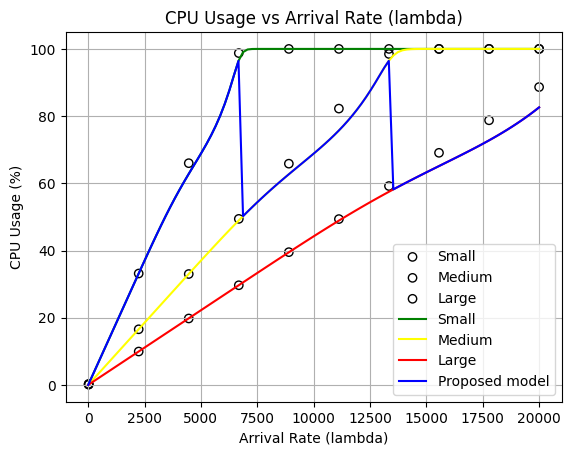

In [16]:
# CPU Usage vs Arrival Rate (lambda)
plt.scatter(lambda_values_jmt, cpu_usage_values_jmt[0], label="Small",
            marker='o', edgecolors='black', facecolors='none')
plt.scatter(lambda_values_jmt, cpu_usage_values_jmt[1], label="Medium",
            marker='o', edgecolors='black', facecolors='none')
plt.scatter(lambda_values_jmt, cpu_usage_values_jmt[2], label="Large",
            marker='o', edgecolors='black', facecolors='none')
plt.plot(lambda_values, cpu_usage_values[0], label="Small" , color='green')
plt.plot(lambda_values, cpu_usage_values[1], label="Medium", color='yellow')
plt.plot(lambda_values, cpu_usage_values[2], label="Large", color='red')
plt.plot(lambda_values, proposed, label="Proposed model", color='blue')
plt.xlabel("Arrival Rate (lambda)")
plt.ylabel("CPU Usage (%)")
plt.title("CPU Usage vs Arrival Rate (lambda)")
plt.grid(True)
plt.legend()
plt.show()

# 2. CPU usage across varying VM counts and task arrival rates.

In [17]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [18]:
# Ranges for the variables
lambda_values = np.linspace(1, 2000, 50).astype(int)  # Adjusted range for lambda
m_values = np.linspace(1, 40, 10).astype(int)  # Adjusted range for VMs

# Create the grid
X, Y = np.meshgrid(lambda_values,m_values)

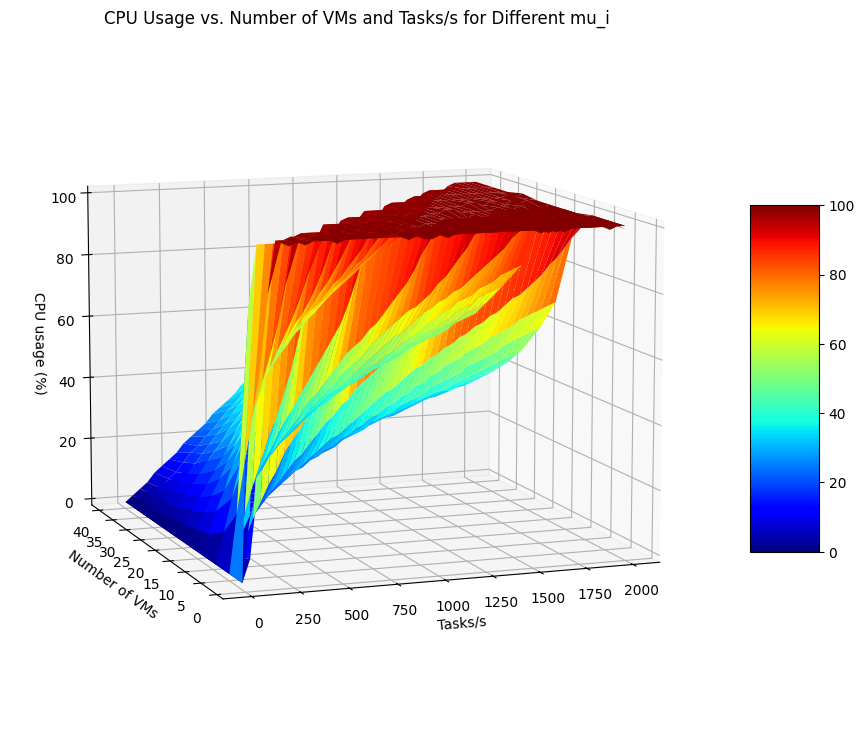

In [19]:
# Create the 3D plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Loop through each mu_i and plot on the same graph
for mu_i in service_rate:
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(Y.shape[1]):
            Z[i, j] = compute_cpu_usage(int(X[i, j]), 1, int(Y[i, j]), mu_i, K) * 100

    surf = ax.plot_surface(X, Y, Z, cmap='jet', rstride=1,
                           cstride=1, edgecolor='none', alpha=1)


fig.colorbar(surf, shrink=0.5, aspect=5)

# Set labels and title
ax.set_xlabel('Tasks/s')
ax.set_ylabel('Number of VMs')
ax.set_zlabel('CPU usage (%)')
ax.set_title('CPU Usage vs. Number of VMs and Tasks/s for Different mu_i')

# Adjust view angle
ax.view_init(elev=10, azim=-110)

# Show plot
plt.show()

# 3. Rejection Probablity

In [20]:
lambda_values = np.linspace(0, 2*10**4, 200).astype(int)
rejection_probablity = [[], [], []]
lambda_values_jmt = np.linspace(20, 2*10**4, 10)
rejection_probablity_jmt = [[], [], []]
proposed = []

In [21]:
# Calculate CPU usage for each lambda
for lambda_i in lambda_values:
    for i, mu_i in enumerate(service_rate):
        # keep N as 1 as we care about only vms
        rejection = compute_rejection_probablity(lambda_i, 1, M, mu_i, K)
        rejection_probablity[i].append(rejection)
    
    if lambda_i < t1:
        proposed.append(rejection_probablity[0][-1])
    elif lambda_i < t2:
        proposed.append(rejection_probablity[1][-1])
    else:
        proposed.append(rejection_probablity[2][-1])
    
   

In [22]:

rejection_probablity_jmt[0] = [19.9601, 677.8005, 671.4770, 679.7308,
                               674.8608, 676.2559, 670.9336, 677.3154, 676.9195, 675.0773]
rejection_probablity_jmt[1] = [20.4216, 1355.0521, 1351.4703, 1338.6376,
                               1344.5802, 1351.7060, 1342.0676, 1345.1148, 1344.5109, 1356.3670]
rejection_probablity_jmt[2] = [20.4133, 2234.0874, 2244.9299, 2266.6905,
                               2234.0432, 2225.6654, 2251.0883, 2252.5419, 2257.5513, 2247.9816]
for i,lambda_i in enumerate(lambda_values_jmt):
    for j, mu_i in enumerate(service_rate):
        rejection_probablity_jmt[j][i] = 1 - (rejection_probablity_jmt[j][i]/lambda_i)

        # model = create_model(f"{mu_i}_{lambda_i}", mu_i, lambda_i, 1, M, K)
        # results = model.getResults()['']["Tasks"]
        # for result in results:
        #     if result["measureType"] == "System Throughput":
        #         print(result['meanValue'])
        #         throughput_ratio = min(float(result['meanValue'])/lambda_i, 1)
        #         rejection_probablity_jmt[j].append(1-throughput_ratio)


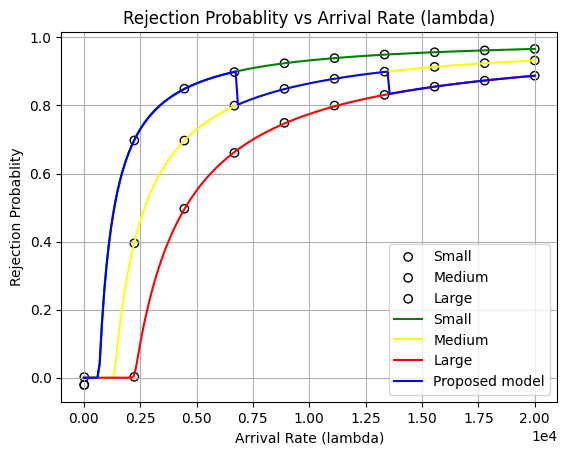

In [23]:
# Plot the graph
plt.scatter(lambda_values_jmt, rejection_probablity_jmt[0], label="Small",
            marker='o', edgecolors='black', facecolors='none')
plt.scatter(lambda_values_jmt, rejection_probablity_jmt[1], label="Medium",
            marker='o', edgecolors='black', facecolors='none')
plt.scatter(lambda_values_jmt, rejection_probablity_jmt[2], label="Large",
            marker='o', edgecolors='black', facecolors='none')
plt.plot(lambda_values, rejection_probablity[0], label="Small", color="green")
plt.plot(lambda_values, rejection_probablity[1], label="Medium", color="yellow")
plt.plot(lambda_values, rejection_probablity[2], label="Large", color="red")
plt.plot(lambda_values, proposed, label="Proposed model", color='blue')
plt.xlabel("Arrival Rate (lambda)")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel("Rejection Probablity")
plt.title("Rejection Probablity vs Arrival Rate (lambda)")
plt.grid(True)
plt.legend()
plt.show()

# 4. Task rejection probability across varying VM counts and task arrival rates.

In [24]:
colors = ['blue', 'green', 'red']

# Define lambda values and VM range
lambda_values = np.linspace(0, 2 * 10**4, 100)
vm_range = np.linspace(1, 41, 40)

# Create meshgrid for surface plot
X, Y = np.meshgrid(lambda_values, vm_range)


C:\Users\wwwsi\AppData\Local\Temp\ipykernel_11628\3629560725.py:72: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


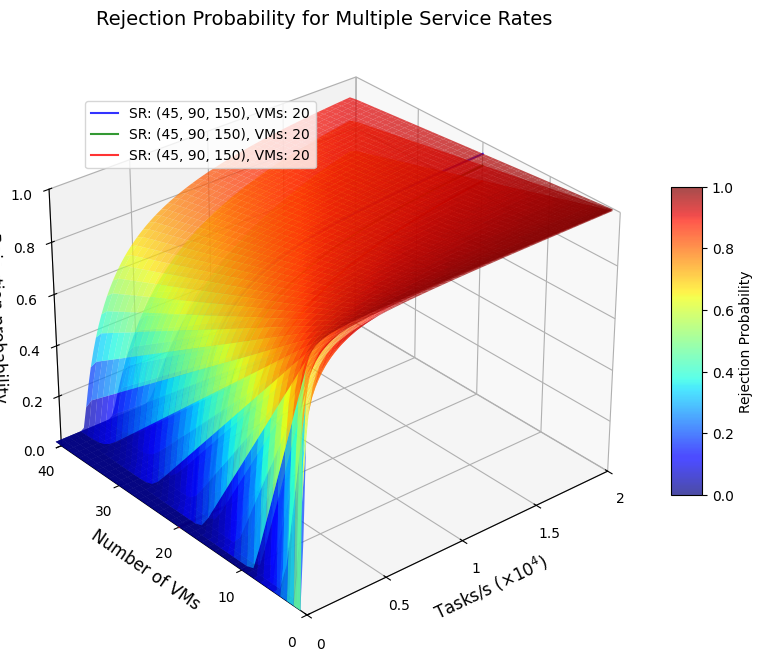

In [25]:
# Create a figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# For storing the last surface for colorbar
last_surf = None

# Plot each service rate with a different colormap section
for idx, mu_i in enumerate(service_rate):
    # Calculate Z values (rejection probability)
    Z = np.zeros((len(vm_range), len(lambda_values)))
    for i, m in enumerate(vm_range):
        m_int = int(m)  # Convert to integer for factorial calculations
        for j, lambda_i in enumerate(lambda_values):
            if lambda_i > 0 and m_int > 0:
                Z[i, j] = compute_rejection_probablity(lambda_i, 1, m_int, mu_i, K)
            elif m_int == 0:
                Z[i, j] = 1  # Always reject when there are no VMs
            else:
                Z[i, j] = 0  # No rejection when no tasks arrive

    # Use a single colormap
    cmap = plt.cm.jet
    vmin, vmax = 0, 1

    # Plot surface
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, vmin=vmin, vmax=vmax, 
                          linewidth=0, antialiased=True, alpha=0.7)
    last_surf = surf
    
    # Add vertical lines for this service rate
    vm_val = 20  # Use one VM value per service rate to avoid cluttering
    vm_idx = np.where(vm_range >= vm_val)[0][0]
    x_line = lambda_values
    y_line = np.ones_like(lambda_values) * vm_val
    z_line = Z[vm_idx, :]
    ax.plot(x_line, y_line, z_line, color=colors[idx], linewidth=1.5, alpha=0.8, 
            label=f'SR: {service_rate}, VMs: {vm_val}')
    
# Create the colorbar
cbar = fig.colorbar(last_surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Rejection Probability')

# Add legend for service rates
ax.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Adjust labels and ticks
ax.set_xlabel('Tasks/s' + r' $(\times 10^4)$', fontsize=12)
ax.set_ylabel('Number of VMs', fontsize=12)
ax.set_zlabel('Rejection probability', fontsize=12)

ax.set_xlim(0, 2 * 10**4)
ax.set_ylim(0, 40)
ax.set_zlim(0, 1)

# X-axis: 0, 0.5, 1, 1.5, 2 (with ×10^4 in the label)
x_ticks = np.array([0, 0.5, 1, 1.5, 2]) * 10**4
ax.set_xticks(x_ticks)
ax.set_xticklabels(['0', '0.5', '1', '1.5', '2'])

# Y-axis: Number of VMs
y_ticks = [0, 10, 20, 30, 40]
ax.set_yticks(y_ticks)

# Z-axis: 0 to 1 in 0.2 increments
ax.set_zticks(np.arange(0, 1.1, 0.2))

# Set view angle
ax.view_init(elev=30, azim=-130)

plt.title('Rejection Probability for Multiple Service Rates', fontsize=14)
plt.tight_layout()
# plt.savefig('multi_service_rates_single_plot.png', dpi=300, bbox_inches='tight')
plt.show()


# 5. Response Time

In [26]:
lambda_values = np.linspace(0, 2*10**4, 100)
response_time = [[], [], []]
lambda_values_jmt = np.linspace(20, 2*10**4, 10)
response_time_jmt = [[], [], []]
proposed = []

In [27]:
for lambda_i in lambda_values:
    for i, mu_i in enumerate(service_rate):
        res = compute_mean_response_time_per_server(lambda_i, N, M, mu_i, K)
        response_time[i].append(res)
    
    if lambda_i < t1:
        proposed.append(response_time[0][-1])
    elif lambda_i < t2:
        proposed.append(response_time[1][-1])
    else:
        proposed.append(response_time[2][-1])

In [28]:
# for lambda_i in lambda_values_jmt:
#     for i, mu_i in enumerate(service_rate):
#         model = create_model(f"{mu_i}_{lambda_i}", mu_i, lambda_i)
#         results = model.getResults()['']["Tasks"]
#         for result in results:
#             if result["measureType"] == "System Response Time":
#                 print(result['meanValue'])
#                 response_time_jmt[i].append(float(result['meanValue']))
response_time_jmt[0] = [1.49E-3, 1.61E-3, 2.67E-3, 0.0607,
                        0.1457, 0.1468, 0.1461, 0.1491, 0.1475, 0.1478]
response_time_jmt[1] = [7.43E-4, 7.48E-4, 8.09E-4, 9.69E-4,
                        1.33E-3, 2.42E-3, 0.0254, 0.0711, 0.0723, 0.0732]
response_time_jmt[2] = [4.46E-4, 4.46E-4, 4.51E-4, 4.73E-4,
                        5.11E-4, 5.89E-4, 6.88E-4, 8.76E-4 , 1.26E-3, 2.24E-3]

c:\Users\wwwsi\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:1355: RuntimeWarning: invalid value encountered in cast
  return np.asarray(x, float)


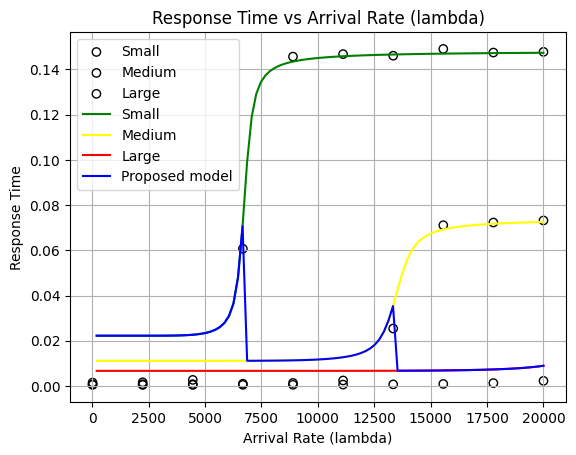

In [29]:
# Plot the graph
plt.scatter(lambda_values_jmt, response_time_jmt[0], label="Small",
            marker='o', edgecolors='black', facecolors='none')
plt.scatter(lambda_values_jmt, response_time_jmt[1], label="Medium",
            marker='o', edgecolors='black', facecolors='none')
plt.scatter(lambda_values_jmt, response_time_jmt[2], label="Large",
            marker='o', edgecolors='black', facecolors='none')
plt.plot(lambda_values, response_time[0], label="Small", color="green")
plt.plot(lambda_values, response_time[1], label="Medium", color="yellow")
plt.plot(lambda_values, response_time[2], label="Large", color="red")
plt.plot(lambda_values, proposed, label="Proposed model", color="blue")
plt.xlabel("Arrival Rate (lambda)")
plt.ylabel("Response Time")
plt.title("Response Time vs Arrival Rate (lambda)")
plt.grid(True)
plt.legend()
plt.show()

# 6. Response time across varying VM counts and task arrival rates.

In [30]:
# Ranges for the variables
lambda_values = np.linspace(1, 2*10**4, 100).astype(int)  # Adjusted range for lambda
m_values = np.linspace(1, 40, 20).astype(int)  # Adjusted range for VMs

# Create the grid
X, Y = np.meshgrid(lambda_values,m_values)

In [31]:
# Calculate CPU usage for each combination
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):    
        lambda_i = int(X[i, j])
        m_3d = int(Y[i, j])
        response_time1 = compute_mean_response_time_per_server(lambda_i, 1, m_3d, service_rate[0], K)
        Z[i, j] = response_time1

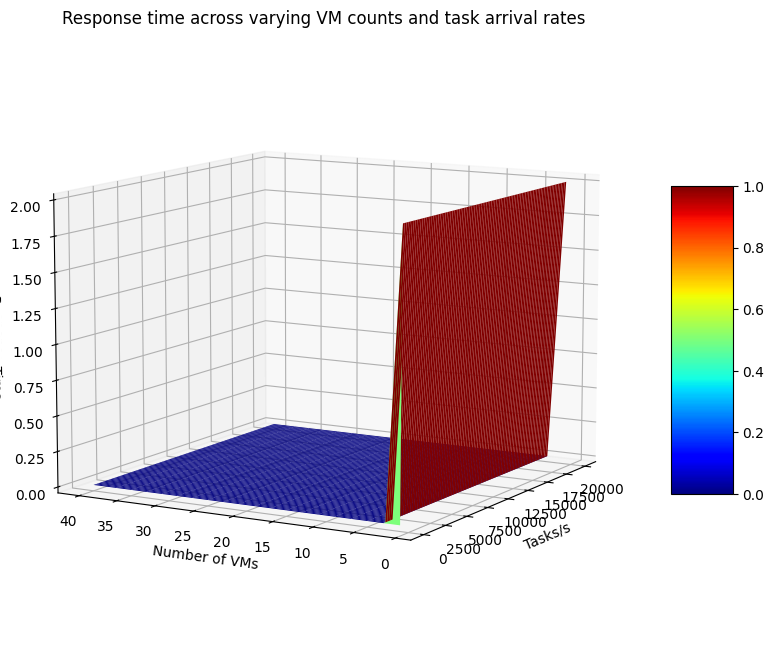

In [32]:
# Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use the 'jet' color map and increase resolution
surf = ax.plot_surface(X, Y, Z, cmap='jet', rstride=1, cstride=1, edgecolor='none')

# Set labels and title
ax.set_xlabel('Tasks/s')
ax.set_ylabel('Number of VMs')
ax.set_zlabel('Response Time')
ax.set_title('Response time across varying VM counts and task arrival rates')

# Adjust view angle to match the first image
ax.view_init(elev=10, azim=-150,roll=0)

# Add color bar
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


# 7. Energy Consumption vs Arrival Rate

In [33]:
# energy consumption per machine
E_base = 100

# energy consumption per vm
E_vm = [20, 35, 50]

# energy consumption for m vm's
E_m_vm = [M*x for x in E_vm]

In [34]:
lambda_values = np.linspace(0, 500, 110).astype(int)
enegry_consumption = [[], [], []]
proposed = []

# Calculate CPU usage for each lambda
for lambda_i in lambda_values:
    for i, mu_i in enumerate(service_rate):
        cpu_usage = compute_cpu_usage(lambda_i, N, M, mu_i, K)
        # for n phyical machine 
        energy_usage = E_base*N + E_m_vm[i] * cpu_usage
        enegry_consumption[i].append(energy_usage)
    
    if lambda_i < t1/40:
        proposed.append(enegry_consumption[0][-1])
    elif lambda_i < t2/40:
        proposed.append(enegry_consumption[1][-1])
    else:
        proposed.append(enegry_consumption[2][-1])

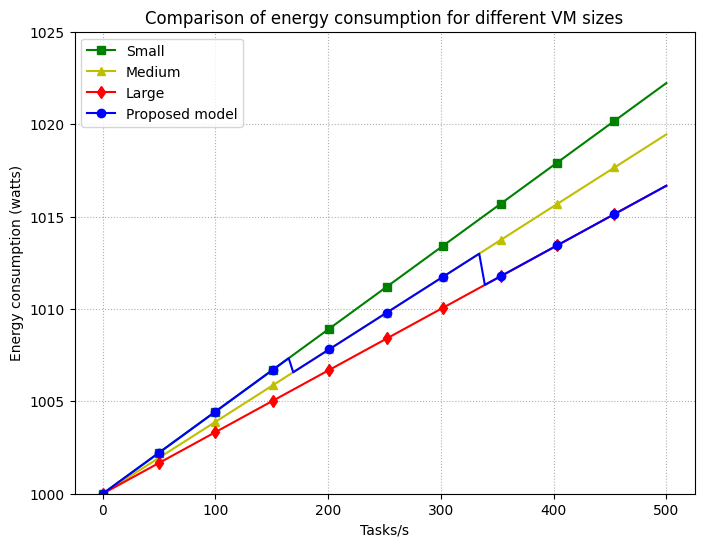

In [35]:
plt.figure(figsize=(8, 6))
# plt.plot(lambda_values, enegry_consumption[0],
#          'g-s', label='Small VMs', linewidth=1)
# plt.plot(lambda_values, enegry_consumption[1],
#          'y-^', label='Medium VMs', linewidth=1)
# plt.plot(lambda_values, enegry_consumption[2],
#          'r-d', label='Large VMs', linewidth=1)
plt.plot(lambda_values, enegry_consumption[0],"g-s", label="Small",markevery=11)
plt.plot(lambda_values, enegry_consumption[1],"y-^", label="Medium",markevery=11)
plt.plot(lambda_values, enegry_consumption[2],"r-d", label="Large",markevery=11)
plt.plot(lambda_values, proposed,'b-o', label="Proposed model",markevery=11)

plt.xlabel('Tasks/s')
plt.ylabel('Energy consumption (watts)')
plt.yticks(np.arange(1000, 1026, 5))
plt.ylim(1000, 1025)
plt.legend()
plt.grid(True, linestyle=':')
plt.title('Comparison of energy consumption for different VM sizes')
plt.show()

# 8. Comparison of system cost for different VM sizes and the proposed model

In [36]:
# Base Costs
BASE_COSTS = {
    'VM': {
        45: 0.0168,   # Small VM cost per unit
        90: 0.0336,   # Medium VM cost per unit
        150: 0.0510   # Large VM cost per unit
    },
    'maintenance': {
        45: 0.002,    # Small maintenance cost per unit
        90: 0.003,    # Medium maintenance cost per unit
        150: 0.004    # Large maintenance cost per unit
    },
    'security': {
        45: 0.005,    # Small security cost per unit
        90: 0.007,    # Medium security cost per unit
        150: 0.009    # Large security cost per unit
    },
    'waiting': 10   # Cost per unit time of a task waiting
}


In [37]:
# Compute Costs based on mu_i values
C_service = {mu: N * M * cost for mu, cost in BASE_COSTS['VM'].items()}
C_maintenance = {mu: N * M * cost for mu,
                 cost in BASE_COSTS['maintenance'].items()}
C_security = {mu: N * M * cost for mu, cost in BASE_COSTS['security'].items()}

# Compute Fixed Costs (Service + Maintenance + Security)
C_fixed = {mu: C_service[mu] + C_maintenance[mu] +
           C_security[mu] for mu in BASE_COSTS['VM'].keys()}


def compute_waiting_cost(lambda_i, N, m, mu_i, mu):
    Wi = compute_mean_waiting_time_in_queue(lambda_i, N, m, mu_i, mu)
    return lambda_i*Wi*BASE_COSTS['waiting']


def compute_total_cost(lambda_i, N, m, mu_i, mu):
    return C_fixed[mu_i] + compute_waiting_cost(lambda_i, N, m, mu_i, mu)


In [38]:
lambda_values = np.linspace(0, 2500, 110)
costs = [[], [], []]
proposed = []
for lambda_i in lambda_values:
    for i, mu_i in enumerate(service_rate):
        cost = compute_total_cost(lambda_i, N, M, mu_i, mu)
        costs[i].append(cost/10)
    
    if lambda_i <= t1/10:
        proposed.append(costs[0][-1])
    elif lambda_i <= t2/10:
        proposed.append(costs[1][-1])
    else:
        proposed.append(costs[2][-1])

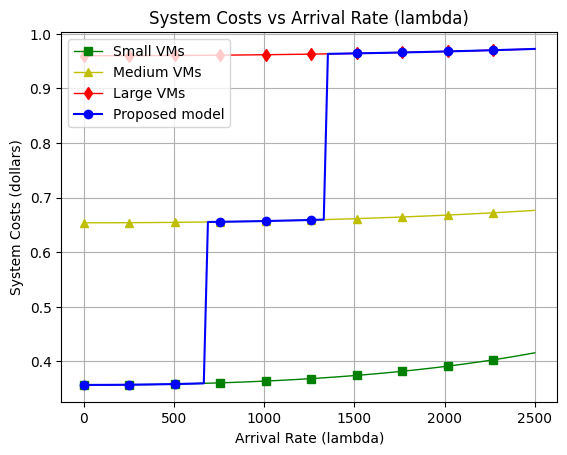

In [39]:
plt.plot(lambda_values, costs[0],
         'g-s', label='Small VMs', linewidth=1, markevery=11)
plt.plot(lambda_values, costs[1],
         'y-^', label='Medium VMs', linewidth=1, markevery=11)
plt.plot(lambda_values, costs[2],
         'r-d', label='Large VMs', linewidth=1, markevery=11)
plt.plot(lambda_values, proposed, 'b-o', label="Proposed model", markevery=11)
plt.xlabel("Arrival Rate (lambda)")
plt.ylabel("System Costs (dollars)")
plt.title("System Costs vs Arrival Rate (lambda)")
plt.grid(True)
plt.legend()
plt.show()